# Enron Data Analysis

<p style="text-align: right;">Chansung, Park</p>

This notebook shows how data analysis on enron dataset can be done. The goal of the analysis is to find the best machine learning algorithm with the best precision and recal metric values. Each algorithms' job on the way is to correctly classify poi(person of interest) from the dataset. POIs are who I am interested in since I think they are strongly related to [Enron Scandal](https://en.wikipedia.org/wiki/Enron_scandal). POIs are chosen mannually and provided by Udacity's "[Intro to Machine Learning](https://www.udacity.com/course/intro-to-machine-learning--ud120)" course. You can think of this notebook as a part of the assignment for the final project from the course.

In order to find the best one, it is good to organize the problem into separate steps below.
- loading proper libraries
- loading the dataset
- inspecting the dataset
- applying any kind of machine learning algorithm for the first time
- selecting features of my own interest
- engineering the data by selected features
- applying the machine learning algorithm for the second time
- finding the best model by applying a variety of machine learning algorithms and techniques

In [216]:
%matplotlib inline

import sys
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from sklearn.model_selection import train_test_split
from tester import test_classifier

with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

It is good practice trying to use pandas library to inspect dataset since pandas provides easier but precise way to do it. In order to do that, I need to convert the raw dataset into pandas dataframe structure.

In [217]:
import pandas as pd
data_df = pd.DataFrame(data_dict).T

In [218]:
data_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


In [219]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
bonus                        146 non-null object
deferral_payments            146 non-null object
deferred_income              146 non-null object
director_fees                146 non-null object
email_address                146 non-null object
exercised_stock_options      146 non-null object
expenses                     146 non-null object
from_messages                146 non-null object
from_poi_to_this_person      146 non-null object
from_this_person_to_poi      146 non-null object
loan_advances                146 non-null object
long_term_incentive          146 non-null object
other                        146 non-null object
poi                          146 non-null object
restricted_stock             146 non-null object
restricted_stock_deferred    146 non-null object
salary                       146 non-null object
shared_receipt_with_poi      146 non-null objec

The data has 21 columns for each person. The columns can be divided into 3 categories like below. Each columns give very nice description about what they are. There are 146 records for the dataset. The each feature(column) of the dataset includes some null values, but it is not depicted in the above table since null value is represented as 'NaN' string value. Later on this analysis, I will go through 'NaN' values for the interesting features.

**financial features:** 
['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

**email features: **
['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

**POI label: **
[‘poi’] (boolean, represented as integer)

After carefully reading through each features, I am going to choose features that will be used to perform machine learning later. Here is a brief explanation what I chose and why.
- poi: this is what I have to classify after all
- salary: I assumed frauds could earn rediculously large amount of salary since they are the ones leading the scandal issue
- bonus: the same reason as salary
- long_term_incentive: maybe the same reason as salary and bonus. But possibly, they could have got incentives for a short period of time
- total_stock_value: this is how actually the frauds are holding their money
- exercised_stock_options: if frauds made lots of money in stock value, they could have sold lots of them at once or little by little gradually
- from_poi_to_this_person: if someone frequently has sent or received emails to/from pois, they could be suspicious
- from_this_person_to_poi: the same reason as from_poi_to_this_person

In [220]:
features_list = ['poi',
                 'salary', 'bonus', 
                 'long_term_incentive', 'total_stock_value', 
                 'exercised_stock_options',
                 'from_poi_to_this_person', 'from_this_person_to_poi']

After choosing the features, it is worth to try them without any engineering. If I can get satisfiable result, I might not need furthur process.

In [221]:
from sklearn.tree import DecisionTreeClassifier

def simple_train_result(data):
    tmp_data = featureFormat(data, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(tmp_data)
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(features_train, labels_train)

    test_classifier(clf, data, features_list)

simple_train_result(data_dict)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.77593	Precision:

The requirement by Udacity's "[Intro to Machine Learning](https://www.udacity.com/course/intro-to-machine-learning--ud120)" course is to get higher value than 0.3 on Recall and Precision metrics. The raw data doesn't meet the requirement. I should go through in more detail on choosing a classifier, choosing right parameters, data engineering, and etc.

# Removing Outliers

Before applying machine learning algorithm directly, it is important to take a look into values belonging to each feature. As a part of data engineering, I am going to inspect values manually since the whole dataset is relatively small. After the inspection, I will remove some data entries that I think them as outliers. I expect to see increment in accuracy, precision, and recall after removing outliers.

### predefine utility function

In order to help with outlier removing process, I am going to define some useful functions.
- **sort_without_nan:** return a dictionary data with sorted data by given feature as an argument. when the value of the given feature for a record is 'NaN', it will be excluded.
- **show_outliers:** return a dictionary data showing only outliers (Q1-1.5\*IQR ~ Q3+1.5\*IQR). the value for the dictionary indicates wheather each record is poi and each record' key
- **remove_outliers_then_print:** remove outliers from designated data, and then show the result.
- **remove_outliers:** remove outliers from designated data. this function is used in remove_outliers_then_print function internally.
- **draw_box_plot:** draw box plot on given data by designated feature.

In [222]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

def number_of_nan(target_feature):
    return len([val for _, val in data_dict.items() if val[target_feature] == 'NaN'])

def sort_without_nan(target_feature):
    tmp_data_dict = {key:val for key, val in data_dict.items() if val[target_feature] != 'NaN'}
    tmp_data_dict = sorted(tmp_data_dict.items(), key=lambda x: x[1][target_feature])
    tmp_data_dict = {item[0]:item[1] for item in tmp_data_dict}
    return tmp_data_dict

def show_outliers(data, target_feature):
    tmp = [val[target_feature] for key, val in data.items()]
    q1 = np.percentile(tmp, 25)
    q3 = np.percentile(tmp, 75)
    iqr = q3-q1
    
    left = q1 - 1.5*iqr
    right = q3 + 1.5*iqr
    
    return {val[target_feature]:[{'poi':val['poi']}, key] for key, val in data.items() if val[target_feature] < left or val[target_feature] > right}

def remove_outliers(data, outlier_keys):
    for outlier_key in outlier_keys:
        if outlier_key in data.keys():
            data.pop(outlier_key)
            
def remove_outliers_then_print(data, outlier_keys, target_feature):
    remove_outliers(data, outlier_keys)
    tmp_data = show_outliers(data, target_feature)
    pp.pprint(tmp_data)

def draw_box_plot(data, target_feature):
    plt.boxplot([val[target_feature] for key, val in data.items()])
    

### outliers in salary

In [223]:
print("number of 'NaN' in salary =>", number_of_nan('salary'))

tmp_data_dict = sort_without_nan('salary')
tmp_data = show_outliers(tmp_data_dict, 'salary')
pp.pprint(tmp_data)

number of 'NaN' in salary => 51
{   477: [{'poi': False}, 'BANNANTINE JAMES M'],
    6615: [{'poi': False}, 'GRAY RODNEY'],
    492375: [{'poi': False}, 'DERRICK JR. JAMES V'],
    510364: [{'poi': False}, 'WHALLEY LAWRENCE G'],
    655037: [{'poi': False}, 'PICKERING MARK R'],
    1060932: [{'poi': False}, 'FREVERT MARK A'],
    1072321: [{'poi': True}, 'LAY KENNETH L'],
    1111258: [{'poi': True}, 'SKILLING JEFFREY K'],
    26704229: [{'poi': False}, 'TOTAL']}


The number of null values in the salary feature is 51. Without consideration on null values, there are 9 outliers in the salary feature. 7 of them are not 'poi'. There are only 2 of them are 'poi' in the group of outliers. It is very obvious the record with the highest salary should not be included because 'TOTAL' indicates the the sum of all salaries.

{   477: [{'poi': False}, 'BANNANTINE JAMES M'],
    6615: [{'poi': False}, 'GRAY RODNEY'],
    63744: [{'poi': False}, 'WESTFAHL RICHARD K'],
    492375: [{'poi': False}, 'DERRICK JR. JAMES V'],
    510364: [{'poi': False}, 'WHALLEY LAWRENCE G'],
    655037: [{'poi': False}, 'PICKERING MARK R'],
    1060932: [{'poi': False}, 'FREVERT MARK A'],
    1072321: [{'poi': True}, 'LAY KENNETH L'],
    1111258: [{'poi': True}, 'SKILLING JEFFREY K']}


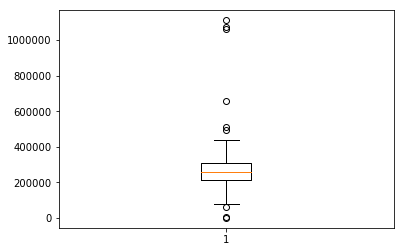

In [224]:
outliers = ['TOTAL']
remove_outliers_then_print(tmp_data_dict, outliers, 'salary')
draw_box_plot(tmp_data_dict, 'salary')

Because very huge value, 'TOTAL', is removed, outliers can be changed. So, I drew the box plot to see the distribution easily after removing the 'TOTAL'. It looks like all outliers listed are far from the range of (Q1-1.5\*IQR ~ Q3+1.5\*IQR). I think I can remove all of them as well

{   76399: [{'poi': False}, 'REYNOLDS LAWRENCE'],
    80818: [{'poi': False}, 'BAZELIDES PHILIP J'],
    85274: [{'poi': False}, 'IZZO LAWRENCE L'],
    428780: [{'poi': False}, 'SHERRIFF JOHN R'],
    440698: [{'poi': True}, 'FASTOW ANDREW S'],
    1072321: [{'poi': True}, 'LAY KENNETH L'],
    1111258: [{'poi': True}, 'SKILLING JEFFREY K']}


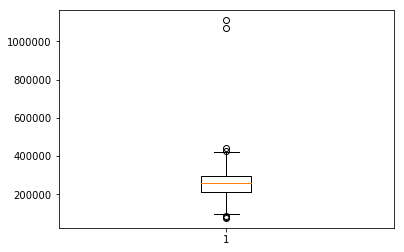

In [225]:
outliers += ['BANNANTINE JAMES M', 'GRAY RODNEY', 'WESTFAHL RICHARD K', 'DERRICK JR. JAMES V', 'WHALLEY LAWRENCE G', 'PICKERING MARK R', 'FREVERT MARK A']
remove_outliers_then_print(tmp_data_dict, outliers, 'salary')
draw_box_plot(tmp_data_dict, 'salary')

After removing all outliers, new outliers appeared. However, it looks like the new outliers are near the range of (Q1-1.5\*IQR ~ Q3+1.5\*IQR), so I think they are ok to be kept.

In [226]:
tmp = data_dict.copy()
remove_outliers(tmp, outliers)
simple_train_result(tmp)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.77323	Precision: 0.29445	Recall: 0.33950	F1: 0.31537	F2:

In [227]:
remove_outliers(data_dict, outliers)

The process of removing the outliers in the salary feature improved the simple default model without any parameter tuning. 

- Accuracy: 0.77593 -> 0.77323
- Precision: 0.25443 -> 0.29445
- Recall: 0.29450 -> 0.33950
- F1: 0.27300 -> 0.31537

Even though the accuracy decreased a little, all other metrics increased a lot. I am expecting the accuracy to  increase later on.

### outliers in bonus

In [228]:
print("number of 'NaN' in bonus =>", number_of_nan('bonus'))

tmp_data_dict = sort_without_nan('bonus')
tmp_data = show_outliers(tmp_data_dict, 'bonus')
pp.pprint(tmp_data)

number of 'NaN' in bonus => 61
{   2500000: [{'poi': False}, 'FALLON JAMES B'],
    2600000: [{'poi': False}, 'MCMAHON JEFFREY'],
    3000000: [{'poi': True}, 'DELAINEY DAVID W'],
    3100000: [{'poi': False}, 'KITCHEN LOUISE'],
    4175000: [{'poi': False}, 'ALLEN PHILLIP K'],
    5249999: [{'poi': True}, 'BELDEN TIMOTHY N'],
    5600000: [{'poi': True}, 'SKILLING JEFFREY K'],
    7000000: [{'poi': True}, 'LAY KENNETH L'],
    8000000: [{'poi': False}, 'LAVORATO JOHN J']}


The number of null values in bonus feature is 61. There are 5 non-poi outliers. Because I think poi could have a comparatively very high or low values, if there is non-poi whose value is higher or lower than poi in the group of outliers, I think they should be removed.

{   2000000: [{'poi': False}, 'SHANKMAN JEFFREY A'],
    3000000: [{'poi': True}, 'DELAINEY DAVID W'],
    5249999: [{'poi': True}, 'BELDEN TIMOTHY N'],
    5600000: [{'poi': True}, 'SKILLING JEFFREY K'],
    7000000: [{'poi': True}, 'LAY KENNETH L']}


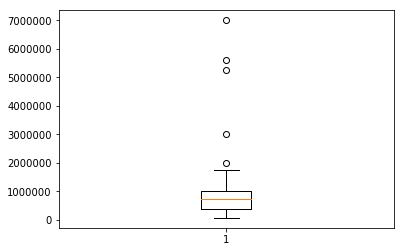

In [229]:
outliers = ['LAVORATO JOHN J', 'ALLEN PHILLIP K', 'KITCHEN LOUISE', 'MCMAHON JEFFREY', 'FALLON JAMES B']
remove_outliers_then_print(tmp_data_dict, outliers, 'bonus')
draw_box_plot(tmp_data_dict, 'bonus')

After removing non-poi outliers, it looks like most of remaining outliers are pois which is good to process the further step.

In [230]:
tmp = data_dict.copy()
remove_outliers(tmp, outliers)
simple_train_result(tmp)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.79042	Precision: 0.37054	Recall: 0.36850	F1: 0.36952	F2: 0.36891
	Total predictio

I see a huge improvements on each metrics comparing to the previous.

- Accuracy: 0.77323 -> 0.79042
- Precision: 0.29445 -> 0.37054
- Recall: 0.33950 -> 0.36850
- F1: 0.31537 -> 0.36952

In [231]:
remove_outliers(data_dict, outliers)

### outliers in long term incentive

I am going through the same process over and over again for the chosen features.

In [232]:
print("number of 'NaN' in long_term_incentive =>", number_of_nan('long_term_incentive'))

tmp_data_dict = sort_without_nan('long_term_incentive')
tmp_data = show_outliers(tmp_data_dict, 'long_term_incentive')
pp.pprint(tmp_data)

number of 'NaN' in long_term_incentive => 77
{   1920000: [{'poi': True}, 'SKILLING JEFFREY K'],
    2234774: [{'poi': False}, 'ECHOLS JOHN B'],
    3600000: [{'poi': True}, 'LAY KENNETH L'],
    5145434: [{'poi': False}, 'MARTIN AMANDA K']}


{   1586055: [{'poi': False}, 'BAXTER JOHN C'],
    1617011: [{'poi': True}, 'RICE KENNETH D'],
    1725545: [{'poi': False}, 'MULLER MARK S'],
    1736055: [{'poi': True}, 'FASTOW ANDREW S'],
    1920000: [{'poi': True}, 'SKILLING JEFFREY K'],
    3600000: [{'poi': True}, 'LAY KENNETH L']}


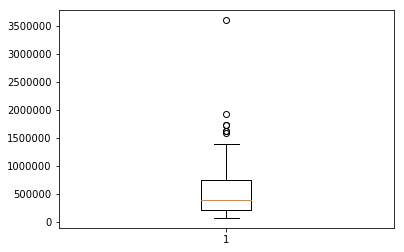

In [233]:
outliers = ['ECHOLS JOHN B', 'MARTIN AMANDA K']
remove_outliers_then_print(tmp_data_dict, outliers, 'long_term_incentive')
draw_box_plot(tmp_data_dict, 'long_term_incentive')

In [234]:
tmp = data_dict.copy()
remove_outliers(tmp, outliers)
simple_train_result(tmp)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.79033	Precision: 0.37620	Recall: 0.39200	F1: 0.38394	F2: 0.38873
	Total predictions: 12000	

Accuracy score stays almost the same, and precision, recall, and f1 score increased. I think this is a good sign.

- Accuracy: 0.79042 -> 0.79033
- Precision: 0.37054 -> 0.37620
- Recall: 0.36850 -> 0.39200
- F1: 0.36952 -> 0.38394

In [235]:
remove_outliers(data_dict, outliers)

### outliers in total stock value

number of 'NaN' in total_stock_value => 19
{   5819980: [{'poi': False}, 'IZZO LAWRENCE L'],
    5898997: [{'poi': False}, 'WALLS JR ROBERT H'],
    6077885: [{'poi': False}, 'CHRISTODOULOU DIOMEDES'],
    6153642: [{'poi': False}, 'KEAN STEVEN J'],
    6391065: [{'poi': True}, 'HANNON KEVIN P'],
    6678735: [{'poi': False}, 'ELLIOTT STEVEN'],
    7256648: [{'poi': False}, 'HORTON STANLEY C'],
    7307594: [{'poi': False}, 'OVERDYKE JR JERE C'],
    7890324: [{'poi': False}, 'REDMOND BRIAN L'],
    8317782: [{'poi': False}, 'DIMICHELE RICHARD G'],
    10623258: [{'poi': False}, 'BAXTER JOHN C'],
    11884758: [{'poi': True}, 'YEAGER F SCOTT'],
    15144123: [{'poi': False}, 'WHITE JR THOMAS E'],
    22542539: [{'poi': True}, 'RICE KENNETH D'],
    23817930: [{'poi': False}, 'PAI LOU L'],
    26093672: [{'poi': True}, 'SKILLING JEFFREY K'],
    30766064: [{'poi': True}, 'HIRKO JOSEPH'],
    49110078: [{'poi': True}, 'LAY KENNETH L']}


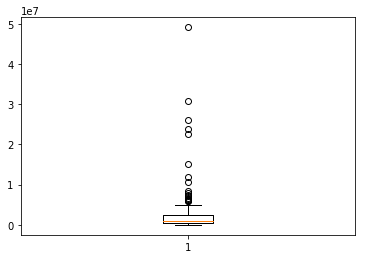

In [236]:
print("number of 'NaN' in total_stock_value =>", number_of_nan('total_stock_value'))

tmp_data_dict = sort_without_nan('total_stock_value')
tmp_data = show_outliers(tmp_data_dict, 'total_stock_value')
pp.pprint(tmp_data)
draw_box_plot(tmp_data_dict, 'total_stock_value')

{   4817796: [{'poi': False}, 'THORN TERENCE H'],
    5819980: [{'poi': False}, 'IZZO LAWRENCE L'],
    5898997: [{'poi': False}, 'WALLS JR ROBERT H'],
    6077885: [{'poi': False}, 'CHRISTODOULOU DIOMEDES'],
    6153642: [{'poi': False}, 'KEAN STEVEN J'],
    6391065: [{'poi': True}, 'HANNON KEVIN P'],
    11884758: [{'poi': True}, 'YEAGER F SCOTT'],
    22542539: [{'poi': True}, 'RICE KENNETH D'],
    26093672: [{'poi': True}, 'SKILLING JEFFREY K'],
    30766064: [{'poi': True}, 'HIRKO JOSEPH'],
    49110078: [{'poi': True}, 'LAY KENNETH L']}


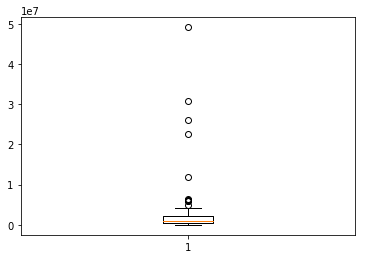

In [237]:
outliers = ['PAI LOU L', 'WHITE JR THOMAS E', 'BAXTER JOHN C', 'DIMICHELE RICHARD G', 'REDMOND BRIAN L', 'OVERDYKE JR JERE C', 'HORTON STANLEY C', 'ELLIOTT STEVEN']
remove_outliers_then_print(tmp_data_dict, outliers, 'total_stock_value')
draw_box_plot(tmp_data_dict, 'total_stock_value')

In [238]:
tmp = data_dict.copy()
remove_outliers(tmp, outliers)
simple_train_result(tmp)

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.80245	Precision: 0.45831	Recall: 0.47550	F1: 0.46675	F2: 0.47196
	Total predictions: 11000	True positives:  951	False positives: 11

- Accuracy: 0.79033 -> 0.80245
- Precision: 0.37620 -> 0.45831
- Recall: 0.39200 -> 0.47550
- F1: 0.38394 -> 0.46675

In [239]:
remove_outliers(data_dict, outliers)

### outliers in exercised stock options

number of 'NaN' in exercised_stock_options => 42
{   4160672: [{'poi': False}, 'REYNOLDS LAWRENCE'],
    4346544: [{'poi': False}, 'WALLS JR ROBERT H'],
    4452476: [{'poi': False}, 'THORN TERENCE H'],
    5127155: [{'poi': False}, 'CHRISTODOULOU DIOMEDES'],
    5538001: [{'poi': True}, 'HANNON KEVIN P'],
    8308552: [{'poi': True}, 'YEAGER F SCOTT'],
    19250000: [{'poi': True}, 'SKILLING JEFFREY K'],
    19794175: [{'poi': True}, 'RICE KENNETH D'],
    30766064: [{'poi': True}, 'HIRKO JOSEPH'],
    34348384: [{'poi': True}, 'LAY KENNETH L']}


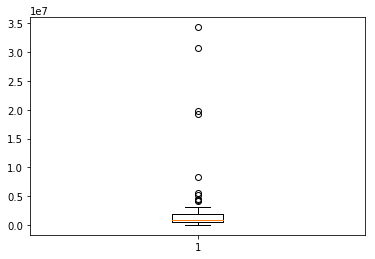

In [240]:
print("number of 'NaN' in exercised_stock_options =>", number_of_nan('exercised_stock_options'))

tmp_data_dict = sort_without_nan('exercised_stock_options')
tmp_data = show_outliers(tmp_data_dict, 'exercised_stock_options')
pp.pprint(tmp_data)
draw_box_plot(tmp_data_dict, 'exercised_stock_options')

For the exercised stock options feature, I don't think there are outliers to be removed. Non-pois belonging to the group of outliers are not far from the range of (Q1-1.5\*IQR ~ Q3+1.5\*IQR), and they are under the pois. I think they could be useful to predict pois later.

### outliers in from poi to this person

number of 'NaN' in from_poi_to_this_person => 50
{   156: [{'poi': False}, 'BUY RICHARD B'],
    180: [{'poi': False}, 'HAEDICKE MARK E'],
    188: [{'poi': False}, 'DONAHUE JR JEFFREY M'],
    199: [{'poi': True}, 'CALGER CHRISTOPHER F'],
    228: [{'poi': True}, 'BELDEN TIMOTHY N'],
    240: [{'poi': True}, 'COLWELL WESLEY'],
    305: [{'poi': False}, 'DIETRICH JANET R']}


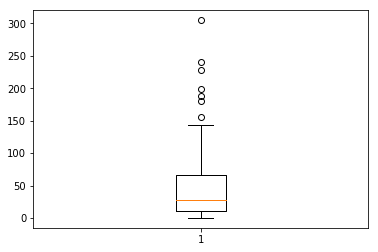

In [241]:
print("number of 'NaN' in from_poi_to_this_person =>", number_of_nan('from_poi_to_this_person'))

tmp_data_dict = sort_without_nan('from_poi_to_this_person')
tmp_data = show_outliers(tmp_data_dict, 'from_poi_to_this_person')
pp.pprint(tmp_data)
draw_box_plot(tmp_data_dict, 'from_poi_to_this_person')

{   144: [{'poi': False}, 'BECK SALLY W'],
    156: [{'poi': False}, 'BUY RICHARD B'],
    180: [{'poi': False}, 'HAEDICKE MARK E'],
    188: [{'poi': False}, 'DONAHUE JR JEFFREY M'],
    199: [{'poi': True}, 'CALGER CHRISTOPHER F'],
    228: [{'poi': True}, 'BELDEN TIMOTHY N'],
    240: [{'poi': True}, 'COLWELL WESLEY']}


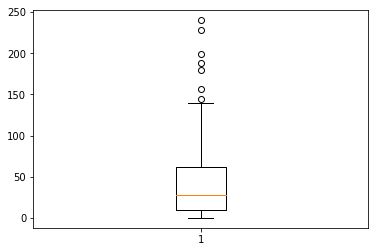

In [242]:
outliers = ['DIETRICH JANET R']
remove_outliers_then_print(tmp_data_dict, outliers, 'from_poi_to_this_person')
draw_box_plot(tmp_data_dict, 'from_poi_to_this_person')

In [243]:
tmp = data_dict.copy()
remove_outliers(tmp, outliers)
simple_train_result(tmp)

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.79482	Precision: 0.43895	Recall: 0.46200	F1: 0.45018	F2: 0.45720
	Total predictions: 11000	True positives:  924	False positives: 1181	Fa

After removing suspected outliers in from_poi_to_this_person feature, all four scores decreased a bit. I think this is not a good sign, so I won't remove those outliers but keep them.

- Accuracy: 0.80245 -> 0.79482
- Precision: 0.45831 -> 0.43895
- Recall: 0.47550 -> 0.46200
- F1: 0.46675 -> 0.45018

### outliers in from this person to poi

number of 'NaN' in from_this_person_to_poi => 50
{   48: [{'poi': True}, 'RIEKER PAULA H'],
    61: [{'poi': False}, 'HAEDICKE MARK E'],
    65: [{'poi': False}, 'SHAPIRO RICHARD S'],
    71: [{'poi': False}, 'BUY RICHARD B'],
    83: [{'poi': False}, 'SHANKMAN JEFFREY A'],
    108: [{'poi': True}, 'BELDEN TIMOTHY N'],
    171: [{'poi': False}, 'KAMINSKI WINCENTY J'],
    194: [{'poi': False}, 'MCCONNELL MICHAEL S'],
    386: [{'poi': False}, 'BECK SALLY W'],
    387: [{'poi': False}, 'KEAN STEVEN J'],
    609: [{'poi': True}, 'DELAINEY DAVID W']}


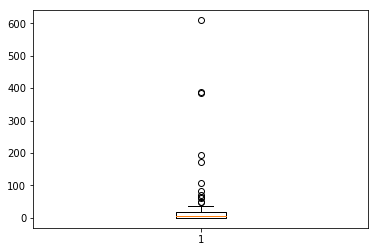

In [244]:
print("number of 'NaN' in from_this_person_to_poi =>", number_of_nan('from_this_person_to_poi'))

tmp_data_dict = sort_without_nan('from_this_person_to_poi')
tmp_data = show_outliers(tmp_data_dict, 'from_this_person_to_poi')
pp.pprint(tmp_data)
draw_box_plot(tmp_data_dict, 'from_this_person_to_poi')

{   38: [{'poi': False}, 'HAYSLETT RODERICK J'],
    48: [{'poi': True}, 'RIEKER PAULA H'],
    108: [{'poi': True}, 'BELDEN TIMOTHY N'],
    609: [{'poi': True}, 'DELAINEY DAVID W']}


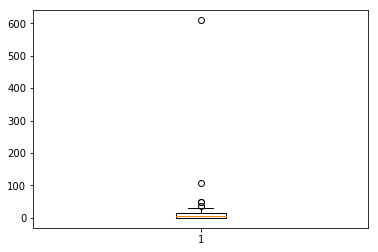

In [245]:
outliers = ['HAEDICKE MARK E', 'SHAPIRO RICHARD S', 'BUY RICHARD B', 'SHANKMAN JEFFREY A', 'KAMINSKI WINCENTY J', 'MCCONNELL MICHAEL S', 'BECK SALLY W', 'KEAN STEVEN J']
remove_outliers_then_print(tmp_data_dict, outliers, 'from_this_person_to_poi')
draw_box_plot(tmp_data_dict, 'from_this_person_to_poi')

In [246]:
tmp = data_dict.copy()
remove_outliers(tmp, outliers)
simple_train_result(tmp)

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.82718	Precision: 0.52442	Recall: 0.53150	F1: 0.52794	F2: 0.53007
	Total predictions: 11000	True positives: 1063	False positives:  964	False negatives:  937	True negatives:

Unlike the from_poi_to_this_person feature, from_this_person_to_poi feature looks like containing lots of outliers which could bring huge improvement when removed. As the simple test shows, it gives better results on the four scores.

- Accuracy: 0.80245 -> 0.82718
- Precision: 0.45831 -> 0.52442
- Recall: 0.47550 -> 0.53150
- F1: 0.46675 -> 0.52794

In [247]:
remove_outliers(data_dict, outliers)

# Adding custom features

As a experimental purpose, I am going to create a PCA applied new feature containing deferral_payments and deferred_income features. Since they have a strong correlation coefficient each other, I think I can put them into the same dimension. I am going to go through the steps below.

- find & remove outliers in deferral_payments and deferred_income
- insert mean value for 'NaN'(null) record for each feature
- scale them into the same range using MinMaxScaler
- apply PCA and create a new feature named, "deferral_payments+deferred_income"
- after applying PCA, remove newly formed outliers in the new feature

### outliers in deferral payments & deferred income

number of 'NaN' in deferral_payments => 85
{   1848227: [{'poi': False}, 'MEYER ROCKFORD G'],
    2144013: [{'poi': True}, 'BELDEN TIMOTHY N'],
    2964506: [{'poi': False}, 'HUMPHREY GENE E']}


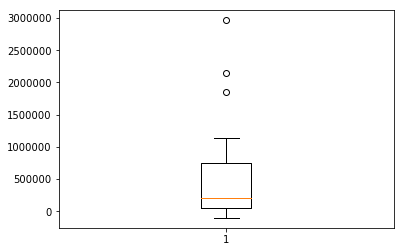

In [248]:
print("number of 'NaN' in deferral_payments =>", number_of_nan('deferral_payments'))

tmp_data_dict_deferral_payments = sort_without_nan('deferral_payments')
tmp_data = show_outliers(tmp_data_dict_deferral_payments, 'deferral_payments')
pp.pprint(tmp_data)
draw_box_plot(tmp_data_dict_deferral_payments, 'deferral_payments')

{2144013: [{'poi': True}, 'BELDEN TIMOTHY N']}


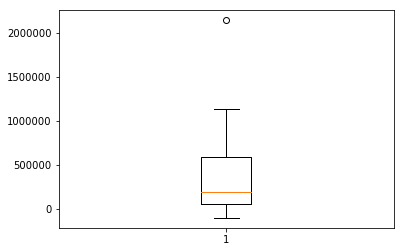

In [249]:
outliers = ['HUMPHREY GENE E', 'MEYER ROCKFORD G']
remove_outliers_then_print(tmp_data_dict_deferral_payments, outliers, 'deferral_payments')
draw_box_plot(tmp_data_dict_deferral_payments, 'deferral_payments')

In [250]:
remove_outliers(data_dict, outliers)

number of 'NaN' in deferred_income => 74
{   -3504386: [{'poi': True}, 'RICE KENNETH D'],
    -3117011: [{'poi': True}, 'HANNON KEVIN P'],
    -2334434: [{'poi': True}, 'BELDEN TIMOTHY N'],
    -1386055: [{'poi': True}, 'FASTOW ANDREW S'],
    -775241: [{'poi': False}, 'DETMERING TIMOTHY J'],
    -719000: [{'poi': False}, 'MULLER MARK S']}


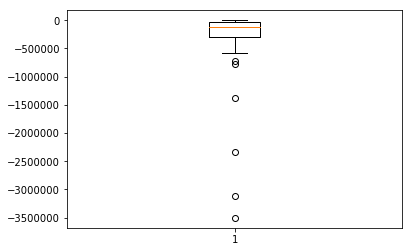

In [251]:
print("number of 'NaN' in deferred_income =>", number_of_nan('deferred_income'))

tmp_data_dict_deferred_income = sort_without_nan('deferred_income')
tmp_data = show_outliers(tmp_data_dict_deferred_income, 'deferred_income')
pp.pprint(tmp_data)
draw_box_plot(tmp_data_dict_deferred_income, 'deferred_income')

{   -3504386: [{'poi': True}, 'RICE KENNETH D'],
    -3117011: [{'poi': True}, 'HANNON KEVIN P'],
    -2334434: [{'poi': True}, 'BELDEN TIMOTHY N'],
    -1386055: [{'poi': True}, 'FASTOW ANDREW S']}


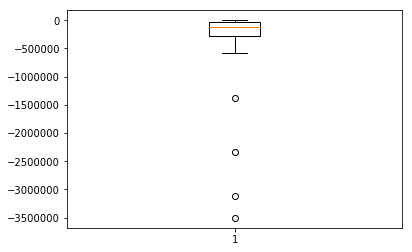

In [252]:
outliers = ['MULLER MARK S', 'DETMERING TIMOTHY J']
remove_outliers_then_print(tmp_data_dict_deferred_income, outliers, 'deferred_income')
draw_box_plot(tmp_data_dict_deferred_income, 'deferred_income')

In [253]:
remove_outliers(data_dict, outliers)

In [254]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()
pca = PCA(n_components=1)

tmp_data_dict_deferral_payments = sort_without_nan('deferral_payments')
tmp_data_dict_deferred_income = sort_without_nan('deferred_income')

mean_deferral_payments = np.mean([val['deferral_payments'] for _, val in tmp_data_dict_deferral_payments.items()])
mean_deferred_income = np.mean([val['deferred_income'] for _, val in tmp_data_dict_deferred_income.items()])

for _, val in data_dict.items():
    if val['deferral_payments'] == 'NaN':
        val['deferral_payments'] = mean_deferral_payments

for _, val in data_dict.items():
    if val['deferred_income'] == 'NaN':
        val['deferred_income'] = mean_deferred_income        
        
tmp_deferral_payments = [val['deferral_payments'] for _, val in data_dict.items()]
tmp_deferred_income = [val['deferred_income'] for _, val in data_dict.items()]

tmp_deferral_payments = scaler.fit_transform(tmp_deferral_payments)
tmp_deferred_income = scaler.fit_transform(tmp_deferred_income)

X = [[tmp_deferral_payments[idx], tmp_deferred_income[idx]] for idx in range(len(tmp_deferral_payments))]
X = pca.fit_transform(X)

for idx, key in enumerate(data_dict):
    data_dict[key]['deferral_payments+deferred_income'] = X[idx][0]
    
features_list.append('deferral_payments+deferred_income')

{   -0.15361820814437926: [{'poi': False}, 'GAHN ROBERT S'],
    0.13117605673791358: [{'poi': False}, 'WASAFF GEORGE'],
    0.25602929000354957: [{'poi': True}, 'FASTOW ANDREW S'],
    0.71085836865686547: [{'poi': True}, 'HANNON KEVIN P'],
    0.81264571295870114: [{'poi': True}, 'RICE KENNETH D'],
    0.81948729303435119: [{'poi': True}, 'BELDEN TIMOTHY N']}


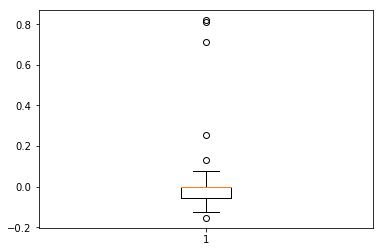

In [255]:
tmp_data_dict = sort_without_nan('deferral_payments+deferred_income')
tmp_data = show_outliers(tmp_data_dict, 'deferral_payments+deferred_income')
pp.pprint(tmp_data)
draw_box_plot(tmp_data_dict, 'deferral_payments+deferred_income')

{   0.25602929000354957: [{'poi': True}, 'FASTOW ANDREW S'],
    0.71085836865686547: [{'poi': True}, 'HANNON KEVIN P'],
    0.81264571295870114: [{'poi': True}, 'RICE KENNETH D'],
    0.81948729303435119: [{'poi': True}, 'BELDEN TIMOTHY N']}


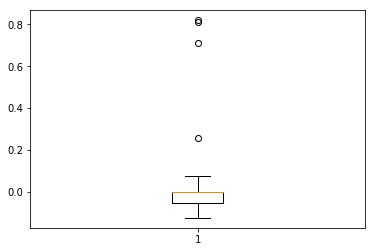

In [256]:
outliers = ['WASAFF GEORGE', 'GAHN ROBERT S']
remove_outliers_then_print(tmp_data_dict, outliers, 'deferral_payments+deferred_income')
draw_box_plot(tmp_data_dict, 'deferral_payments+deferred_income')

In [257]:
remove_outliers(data_dict, 'deferral_payments+deferred_income')

# After removing outliers & adding new feature

After removing outliers, I think it is worth to try it directly and compare the result with the previously experimented one.

In [258]:
simple_train_result(data_dict)

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.83008	Precision: 0.49034	Recall: 0.49500	F1: 0.49266	F2: 0.49406
	Total predictions: 12000	True positives:  990	False pos

It looks like removing the outliers did the trick to meet the requirement. However, I believe in that I can get much better result if I try my best to find the best parameters. 

# Find the best model

In order to find the best model (having the best parameters as much as I can find), I am going to define 2 functions

- **test_classifier_return_metrics:** measures each metric score values and return them for later use
- **test_classifiers:** attempt to find the best model using the follow steps.
 - Loop over k=1 ~ k=len(feature_list)
 - Pipeline SelectKBest with base classfier. The base calssfier can be anything like DecisionTree, Adaboost, or etc,. For every loop, k value for SelectKBest is changed to find the best feature list for a given number of feature limit. I also want to track and compare each model with different k value later.
 - Perform GridSearchCV with the previously made Pipeline. Variety of different parameters for different classifiers specified in the Pipeline can be given as a parameter. StratifiedShuffleSplit is also used to perform cross validation.
 - retrieve the best model(estimator) and feature list used for later use

In [111]:
def test_classifier_return_metrics(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    
    total_predictions = 0
    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    f2 = 0
    
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    
    for train_idx, test_idx in cv:
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
            
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        return accuracy, precision, recall, f1, f2
    except:
        return accuracy, precision, recall, f1, f2
    

In [54]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

def test_classifiers(base_clf, parameters, n_splits=1000):
    data = featureFormat(data_dict, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)

    tmp_features_list = features_list.copy()
    tmp_features_list.remove('poi')
    
    result_clf = []
    result_features = []
    
    for i in range(len(tmp_features_list)):
        k = i+1
        skb = SelectKBest(f_classif, k=k)
        sss = StratifiedShuffleSplit(labels, n_splits, random_state = 42)
        pipeline = Pipeline([('skb', skb), ('clf', base_clf)])

        grid = GridSearchCV(pipeline, param_grid=parameters, cv=sss, scoring='f1')
        grid.fit(features, labels)
        
        model = grid.best_estimator_
        feature_idx = grid.best_estimator_.named_steps['skb'].get_support(indices=True)
        new_features_list = []
        
        for idx in feature_idx:
            new_features_list.append(tmp_features_list[idx])
        
        if 'poi' not in new_features_list:
            new_features_list.insert(0, 'poi')
        
        result_clf.append(model)
        result_features.append(new_features_list)
        
        print('k =',k, 'is done...')
    
    return result_clf, result_features

In [64]:
def add_result_to_all(target, name, result_clf, result_features):
    for idx in range(len(result_clf)):
        if idx in target.keys():
            target[idx].append({name: [result_clf[idx], result_features[idx]]})
        else:
            target[idx] = []
            target[idx].append({name: [result_clf[idx], result_features[idx]]})

## Running variety of classifiers with variety of parameters.

### DecisionTreeClassifier

In [68]:
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings(action='ignore')

results = {}

parameters = {'clf__criterion': ['gini', 'entropy'], 'clf__min_samples_split': [2, 5, 10, 15, 20, 30]}
dtc_clf = DecisionTreeClassifier(random_state=42)

result_clf, result_features = test_classifiers(dtc_clf, parameters)
add_result_to_all(results, 'decision tree', result_clf, result_features)

k= 1 is done...
k= 2 is done...
k= 3 is done...
k= 4 is done...
k= 5 is done...
k= 6 is done...
k= 7 is done...
k= 8 is done...


### AdaBoostClassifier

In [73]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {'clf__learning_rate': [1, 0.1, 0.05, 0.01, 0.005],
              'clf__algorithm': ('SAMME', 'SAMME.R'),
              'clf__n_estimators': [3, 7, 10, 30, 50]}
adb_clf = AdaBoostClassifier(random_state=42)

result_clf, result_features = test_classifiers(adb_clf, parameters)
add_result_to_all(results, 'adaboost', result_clf, result_features)

k= 1 is done...
k= 2 is done...
k= 3 is done...
k= 4 is done...
k= 5 is done...
k= 6 is done...
k= 7 is done...
k= 8 is done...


### RandomForestClassifier

In [74]:
from sklearn.ensemble import RandomForestClassifier

parameters = {'clf__n_estimators': [10, 15, 20],
              'clf__criterion': ['gini', 'entropy'],
              'clf__min_samples_split': [10, 15, 20],
              'clf__oob_score': [True],
              'clf__max_features': ['sqrt', 'log2'],
              'clf__class_weight': ['balanced']},

rf_clf = RandomForestClassifier(random_state=42, oob_score=True)
result_clf, result_features = test_classifiers(rf_clf, parameters)
add_result_to_all(results, 'random forest', result_clf, result_features)

k= 1 is done...
k= 2 is done...
k= 3 is done...
k= 4 is done...
k= 5 is done...
k= 6 is done...
k= 7 is done...
k= 8 is done...


### Support Vector Machine

In [75]:
from sklearn.svm import SVC

parameters = {'clf__kernel': ['rbf', 'sigmoid'],
              'clf__class_weight': ['balanced'],
              'clf__max_iter': [10, 20, 30],
              'clf__decision_function_shape': ['ovo', 'ovr']}
svc_clf = SVC(random_state=42)
result_clf, result_features = test_classifiers(svc_clf, parameters)
add_result_to_all(results, 'svm', result_clf, result_features)

k= 1 is done...
k= 2 is done...
k= 3 is done...
k= 4 is done...
k= 5 is done...
k= 6 is done...
k= 7 is done...
k= 8 is done...


### Gaussian Naive Bayse

In [70]:
from sklearn.naive_bayes import GaussianNB

parameters = {}
nb_clf = GaussianNB()
result_clf, result_features = test_classifiers(nb_clf, parameters)
add_result_to_all(results, 'gaussian nb', result_clf, result_features)

k= 1 is done...
k= 2 is done...
k= 3 is done...
k= 4 is done...
k= 5 is done...
k= 6 is done...
k= 7 is done...
k= 8 is done...


## Test & Compare each model in a group of k

In order to see how good they are, I am going to run test_classifier_return_metrics function to retrieve accuracy, precision, recall, and f1 scores from each model. I am going to group them into different number of features.

In [122]:
model_names = []
count = 0

metric_results = {}

print('k, clf name, f1, accuracy')

for idx in results.keys():
    f1_results = []
    acc_results = []
    feature_list = []
    
    print('k =', idx+1)
    
    for model in results[idx]:
        model_name = list(model.keys())[0]
        
        if count == 0:
            model_names.append(model_name)

        clf = model[model_name][0]
        feature = model[model_name][1]

        accuracy, _, _, f1, _ = test_classifier_return_metrics(clf, data_dict, feature)

        f1_results.append(f1)
        acc_results.append(accuracy)
        feature_list.append(feature)

        metric_results[idx] = [acc_results, f1_results, feature_list]
        
        print('\t', model_name, f1, accuracy)
    
    count += 1

k, clf name, f1, accuracy
k = 1
	 decision tree 0.7053451517593339 0.8171666666666667
	 gaussian nb 0.5385878489326765 0.7658333333333334
	 adaboost 0.715927750410509 0.827
	 random forest 0.6830785177507126 0.7961666666666667
	 svm 0 0.6666666666666666
k = 2
	 decision tree 0.6499454743729552 0.8165714285714286
	 gaussian nb 0.5132275132275133 0.7897142857142857
	 adaboost 0.6567493112947659 0.822
	 random forest 0.6389462809917356 0.8002857142857143
	 svm 0 0.7142857142857143
k = 3
	 decision tree 0.6484660849985927 0.8215714285714286
	 gaussian nb 0.5241837968561064 0.7751428571428571
	 adaboost 0.649746192893401 0.8225714285714286
	 random forest 0.5840478046245778 0.7712857142857142
	 svm 0 0.7142857142857143
k = 4
	 decision tree 0.6264665757162347 0.8631
	 gaussian nb 0.6086714841578654 0.8592
	 adaboost 0.5889967637540453 0.8603
	 random forest 0.5607476635514018 0.8167
	 svm 0.3333333333333333 0.2
k = 5
	 decision tree 0.6398293788323114 0.8649
	 gaussian nb 0.5793262309242729

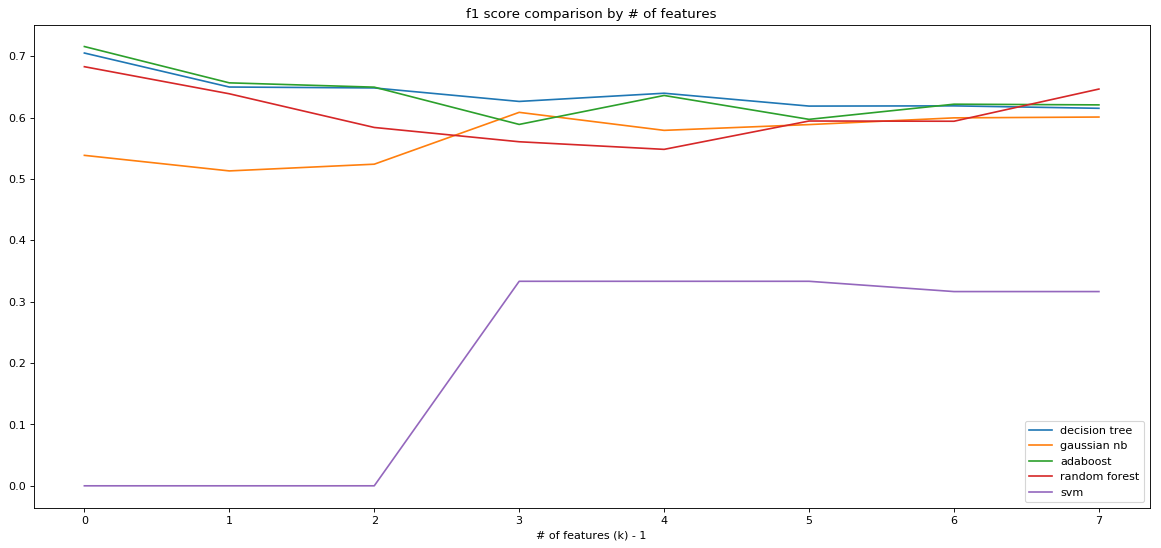

In [156]:
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.title("f1 score comparison by # of features")
plt.xlabel("# of features (k) - 1")

for idx in range(5):
    plt.plot([val[1][idx] for k, val in metric_results.items()])
    plt.legend(model_names)

For f1 score which could also represent how good precision and recall are, **'Adaboost'** achieved the best result with two features. The **f1 score** for 'Adaboost' is approximately **0.7159** with the **feature list** of **'poi' and 'bonus'**. The **paremeters** used to achieve the result are **'SAMME.R'** for the algorithm choice, **0.05** for the learning rate, and **30** for the number of estimators.

Even though 'Adaboost' achieved the best result, other models also could get competitive result as well. Most of them achieved better than 0.3 score on precision and recall. 

In [175]:
print("the best pipeline model for f1 score")
print(results[0][2]['adaboost'][0], '\n')

print("the best feature list for the chosen model")
print(results[0][2]['adaboost'][1], '\n')

print("the f1 score of the chosen model")
print(metric_results[0][1][2])

the best pipeline model for f1 score
Pipeline(steps=[('skb', SelectKBest(k=1, score_func=<function f_classif at 0x1134c1048>)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=30, random_state=42))]) 

the best feature list for the chosen model
['poi', 'bonus'] 

the f1 score of the chose model
0.715927750410509


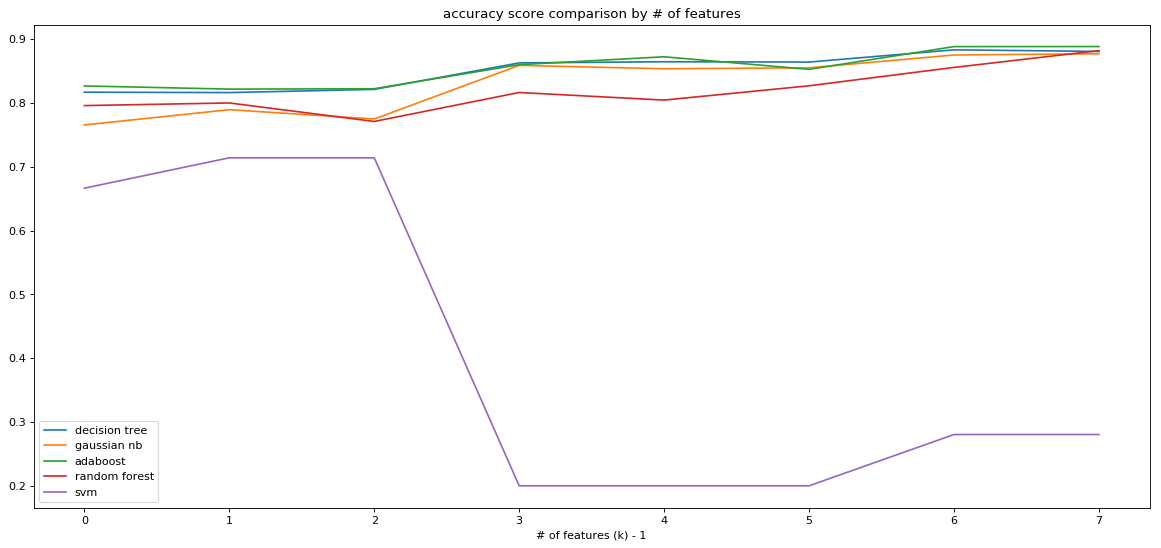

In [158]:
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')

plt.title("accuracy score comparison by # of features")
plt.xlabel("# of features (k) - 1")

for idx in range(5):
    plt.plot([val[0][idx] for k, val in metric_results.items()])
    plt.legend(model_names)

For accuracy score, it is hard to tell which one is really good because every algorithm choice looks having similar accuracy. I would choose the adaboost model just like I chose it for f1 score section. As the number of feature increases, the model complexity also get increased. This possibly could mean they can get better accuracy score, but they might be overfitted. It is almost always better to avoid overfitting issue, and f1 score could measure how well a model does a job about it.

As Adaboost showed the best result on f1 score with the least number of feature, I think it is not overfitted, and the accuracy score for the corresponding model is not bad as well.

In [261]:
print("the accuracy score of the chosen model")
print(metric_results[0][0][2])

the accuracy score of the chosen model
0.827


### Conclusion

The best model I could find is 'Adaboost'. The parameters with the below, it did the best job.

- feature list: 'poi', 'bonus'
- algotirthm: 'SAMME.R'
- learning rate: 0.05
- number of estimators: 30

And the scores are

- accuracy: 0.827
- f1: 0.7159

This model achieved the best f1 score comparing to other models, DecisionTree, Gaussian Naive Bayes, Random Forest, and Support Vector Machine. While having the best f1 score, the number of feature used is only 2. I think it could mean this model is not overfitted much. Furthermore, it achieved the best accuracy as well in the group of other models under the same number of features.